## Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne


# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função `matplotlib.pyplot.psd` que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (_Power Spectrum Density_)

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [ ]:
def print_graphs(data):
    for i in range(0, 84, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 84, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 84, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [ ]:
data = np.load("../dataset/sc/DataSet_A_2/single/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.swapaxes(2, 1)
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
data.shape

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

In [ ]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [ ]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../dataset/sc/DataSet_A_2/single/label_unificada.npy")
labels = labels.swapaxes(1, 0)
labels = labels.reshape(labels.shape[1] * labels.shape[2])
print(labels, labels.shape)
np.save("../dataset/sc/DataSet_A_2/single/labels_formated.npy", labels)

In [ ]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(labels.shape[0], dtype=int),
    le.fit_transform(labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()


# Filtrando e salvando os dados pelo objeto MNE

In [ ]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)

# salvando os dados
mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/single/mne_data.fif", overwrite=True)

# Criação do MNE para o multi target

Definição de função para imprimir os dados no domínio do tempo e da frequência:

In [20]:
def print_graphs(data):
    for i in range(0, 100, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 100, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 100, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

In [21]:
data = np.load("../dataset/sc/DataSet_A_2/multi/data_unificada.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
#data = data.swapaxes(2, 1)
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
data.shape

(10, 10, 8192)


(100, 8192)

Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

In [ ]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta `MNE`:

In [22]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [23]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../dataset/sc/DataSet_A_2/multi/label_unificada.npy")
#labels = labels.swapaxes(1, 0)
labels = labels.reshape(labels.shape[0] * labels.shape[1])
print(labels, labels.shape)
np.save("../dataset/sc/DataSet_A_2/multi/labels_formated.npy", labels)

[7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2 6.  6.5 7.5 7.
 6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2 6.  6.5
 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.  6.  8.2
 6.  6.5 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2 9.3 6.
 6.  8.2 6.  6.5 7.5 7.  6.  6.  7.5 8.2 7.  8.2 6.  7.5 6.  6.  8.2 8.2
 9.3 6.  6.  8.2 6.  6.5 7.5 7.  6.  6. ] (100,)


In [25]:
# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
print(data_correct.shape)
# adicionando label como "épocas" do sinal

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(100, dtype=int),
    le.fit_transform(labels))
)
event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

(100, 1, 8192)
Not setting metadata
100 matching events found
No baseline correction applied
0 projection items activated


Number of events,100
Events,6: 406.5: 57: 107.5: 158.2: 259.3: 5
Time range,0.000 – 15.998 s
Baseline,off


In [ ]:
import warnings
warnings.filterwarnings('ignore')

for i in range(len(mne_data)):
    # view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13,
                                   verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--',
                color='green')
    plt.show()
print()

# Filtrando e salvandos os dados pelo objeto MNE

In [ ]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12)

# salvando os dados
mne_data_filtered.save(fname="../dataset/sc/DataSet_A_2/multi/mne_data.fif", overwrite=True)

### Tarefas

- Estudar e utilizar os exemplos já apresentados no repositório `tutoriais` e criar o objeto `mne.EpochArray` para os dados *single* e *multi-target* (`AVI dataset`);
- Estudar documentos MNE para realizar a aplicação dos filtros temporais a partir de objetos `mne.EpochArray` (sempre verificando as frequências utilizadas como targets dos `datasets`). Isto também para os dados *single* e *multi-target* (`AVI dataset`);
- **Ótimo**: elaborar toda a aplicação já realizada até o ponto anterior para o *dataset* `Beta`.

# Criação do mne para o beta

In [44]:
def print_graphs(data):
    for i in range(0, 10, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 10, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 10, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

In [46]:
data = np.load("../dataset/beta/data_unificada.npy")
print(data.shape)
# (64, 750, 160)
# Transpondo dados para organizar os dados na última dimensão
#data = data.swapaxes(2, 1)
data = data.reshape(data.shape[2] * data.shape[3], data.shape[0], data.shape[1])
data.shape

(64, 750, 4, 40)


(160, 64, 750)

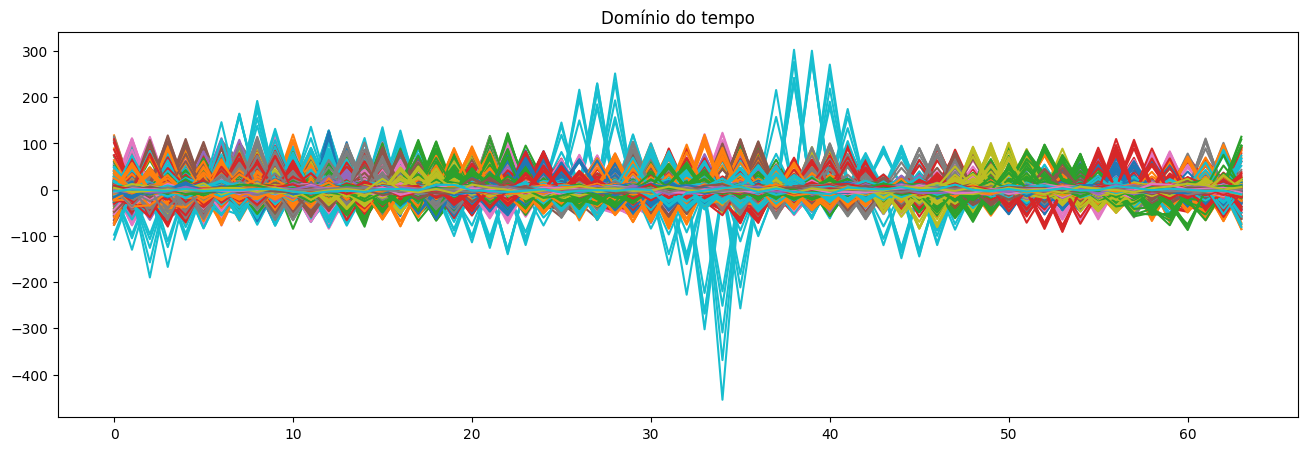

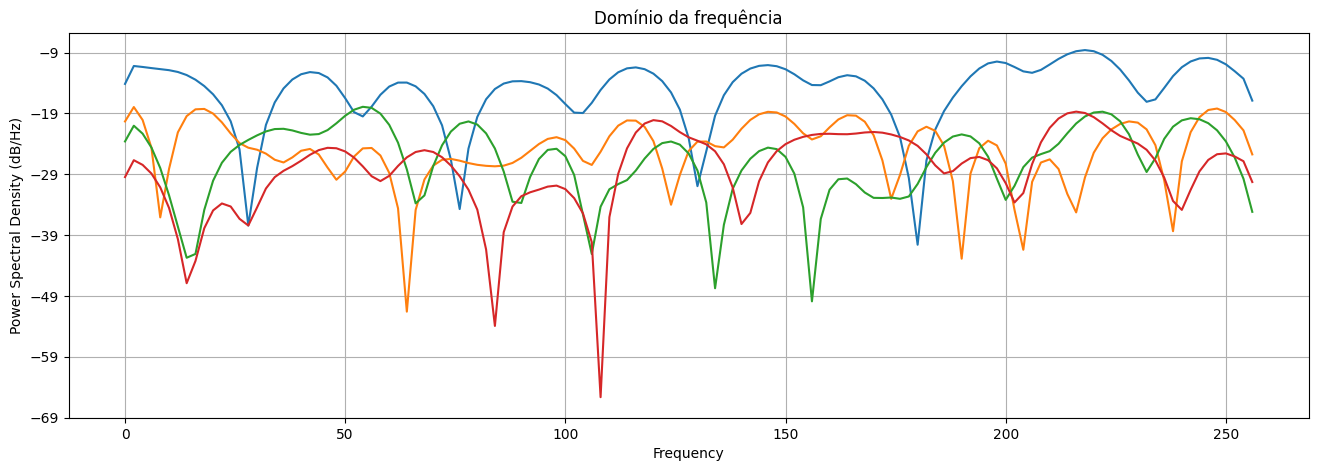

C:\Users\gregu\AppData\Local\Temp\ipykernel_7560\801008969.py:13: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=64).
  plt.specgram(data[i,:], Fs=512)


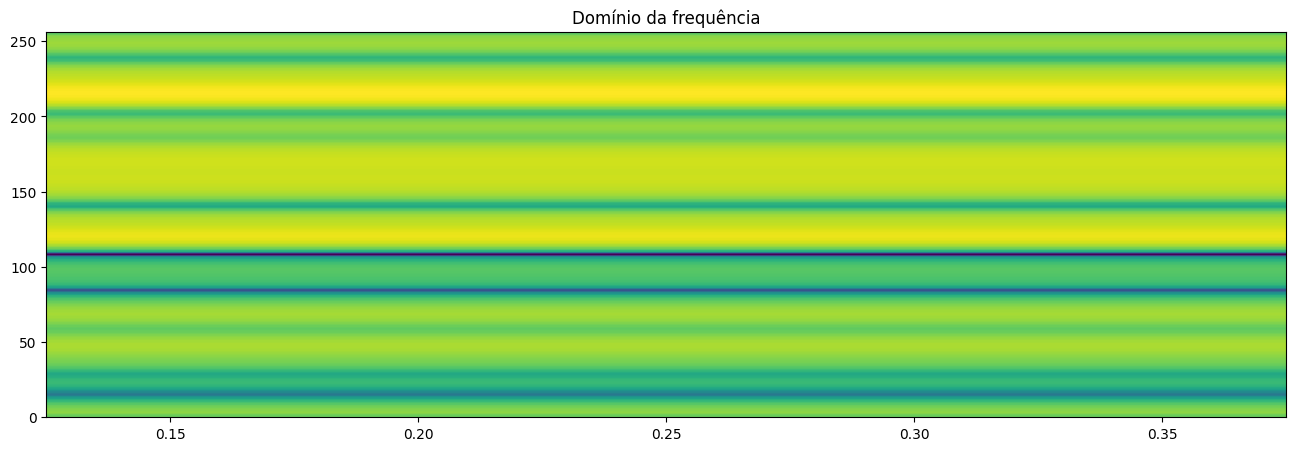

In [28]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

In [50]:
# criação de um objeto "info"
n_channels = 64
sfreq = 250
#Esses são os canais que devo usar
#ch_names = ['Pz', 'PO3', 'PO5', 'PO4', 'PO6', 'POz', 'O1', 'Oz', 'O2']
ch_names = []
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

ValueError: ch_types and ch_names must be the same length (1 != 64) for ch_types=['eeg']

In [36]:
from sklearn.preprocessing import LabelEncoder

labels = np.load("../dataset/beta/label_unificada.npy")
#labels = labels.swapaxes(1, 0)
labels = labels.reshape(labels.shape[0] * labels.shape[1])
print(labels, labels.shape)
np.save("../dataset/sc/DataSet_A_2/multi/labels_formated.npy", labels)

[ 8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.  11.2
 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8 14.
 14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8  8.   8.2  8.4] (40,)


In [49]:
data_correct = data.reshape(data.shape[0], 1, data.shape[2])
print(data_correct.shape)

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(40, dtype=int),
    le.fit_transform(labels))
)
event_dict = {'8':0, '8.2':1, '8.4':2, '8.6':3, '8.8':4, '9':5,
              '9.2':6, '9.4':7, '9.6':8, '9.8':9, '10':10, '10.2':11,
              '10.4':12, '10.6':13, '10.8':14, '11':15, '11.2':16, '11.4':17,
              '11.6':18, '11.8':19, '12':20, '12.2':21, '12.4':22, '12.6':23,
              '12.8':24, '13':25, '13.2':26, '13.4':27, '13.6':28, '13.8':29,
              '14':30, '14.2':31, '14.4':32, '14.6':33, '14.8':34, '15':35,
              '15.2':36, '15.4':37, '15.6':38, '15.8':39}
mne_data = mne.EpochsArray(data, info, events, event_id=event_dict)
mne_data

ValueError: cannot reshape array of size 7680000 into shape (160,1,750)